## Data Analysis Workshop -- New Horizons -- SPICE navigation library
## 26-Sep-2016 Henry Throop

Import the necessary Python libraries.

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cspice
import astropy.units as u
import os.path
from astropy.io import fits
import math

r2d = 360 / 2 / math.pi  # Conversion from radians to degrees 

Tell SPICE to import the necessary kernel files. A list of kernel files is provided in the kernels.tm file... TM = 'text metakernel'.

In [11]:
file_kernels = 'kernels.tm'
cspice.furnsh(file_kernels)

Now convert from a UTC time into the spacecraft ET ('ephemeris time'). ET is a floating point number, which starts at roughly the start of the US spaced program (1957 AD). Many SPICE routines use ET (rather than UTC) for consistency - it is a lot easier to do math on a floating-point value, than convert a string back and forth many times.

We use cspice.utc2et() ('Universal Coordinate Time to Ephemeris Time').

In [28]:
utc = '2015 Jul 14 00:00:00'
et = cspice.utc2et(utc)

SPKEZR ('Spacecraft Kernel, Easier') is SPICE's main position reader. It takes as input the target name, the ET, the frame (always use 'J2000'), the aberration correction (usually use 'LT': make light-time corrections), and the observer name.

SPKEZR returns a 6-element vector, plus a scalar. In the vecotr, the first three elements are the xyz position (in km), and the second three are the xyz velocity (in km/sec). For this example, we will just take the first three elements, extracted as vec[0:3]. The scalar returned is the light-travel time, in seconds.

For instance, to find the distance between Mars and Earth on 2015 1 July, we can do this below. We are using Astropy's Units Library to convert from km to AU.

In [56]:
utc = '1 Jul 2015 00:00:00'
et = cspice.utc2et(utc)
(vec,lt) = cspice.spkezr('Pluto', et, 'J2000', 'LT', 'Earth')

In [57]:
dist = cspice.vnorm(vec[0:3])*u.km
print "Distance from Pluto to Earth at {} = {:.2f}".format(utc, dist.to(u.AU))
print "Light-travel time = {:.2f} secconds.".format(lt)

Distance from Pluto to Earth at 1 Jul 2015 00:00:00 = 31.89 AU
Light-travel time = 15912.56 secconds.


In [69]:
(vector_nh, lt) = cspice.spkezr('Pluto', et, 'J2000', 'LT', 'New Horizons')
(vector_earth, lt) = cspice.spkezr('Pluto', et, 'J2000', 'LT', 'Earth')

Now that we have computed the vector, take the first three elements to extract the xyz vector from Pluto to New Horizons. Then get the length of this vector using cspice.vnorm ('vector normalize').

In [70]:
dist = cspice.vnorm(vector_nh[0:3])
print "At time {}, distance from Pluto to New Horizons = {:.2f} km".format(utc, dist)

dist_earth = cspice.vnorm(vector_earth[0:3])
km_per_au = float((1*u.au) / (1*u.km))

print "At time {}, distance from Earth to New Horizons = {:.2f} AU".\
format(utc, dist_earth/km_per_au)

At time 1 Jul 2015 00:00:00, distance from Pluto to New Horizons = 16067834.84 km
At time 1 Jul 2015 00:00:00, distance from Earth to New Horizons = 31.89 AU


Look up the position of NH as seen from Earth. For this we use the RECRAD function ('Rectangular to RA-Dec').

In [71]:
(dist,ra,dec) = cspice.recrad(vector_nh[0:3])
print "Position of New Horizons seen from Pluto: RA={} deg, Dec={} deg.".format(ra*r2d, dec*r2d)

Position of New Horizons seen from Pluto: RA=270.638493978 deg, Dec=-14.6117624436 deg.


## Now do some quick image processing.

Read a FITS image into an array, using astropy's fits.open(). This is a New Horizons file, in this case of Charon.  

lor : LORRI instrument (NH's 1024 x 1024 CCD)  

02998997004: This is the MET time ('Mission Elapsed Time') -- seconds since launch in January 2006.  

0x630_sci : Indicates this is a calibrated LORRI file  

.fit      : FITS extension


In [65]:
file_im = os.path.join('images', 'lor_0298997004_0x630_sci.fit')
hdulist = fits.open(file_im)

Read the FITS image's header, and display it.  

The header is a text list of fields, which are metadata to accompany the image data. They are saved in the same file as the image data. You can access them by using python's dictionary commands, like below. 

In [63]:
header = hdulist['PRIMARY'].header  # 'PRIMARY' is the main FITS extension. We always use that one.
header

SIMPLE  =                    T / Written by IDL:  Wed Apr  6 04:34:04 2016      
BITPIX  =                  -32 / IEEE single precision floating point           
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024 /Number of positions along axis 1                
NAXIS2  =                 1024 /Number of positions along axis 2                
EXTEND  =                    T                                                  
MISSION = 'New Horizons'       / Mission name                                   
HOSTNAME= 'NEW HORIZONS'       / Host name (PDS terminology)                    
HOSTID  = 'NH      '           / Host ID (PDS terminology)                      
INSTRU  = 'lor     '           / Instrument                                     
APID    = '0x630   '           / Application ID of science data                 
MET     =            298997004 / First packet MET (from instrument or HS bus)   
METEND  =            2989970

Read several fields from the header.

In [74]:
sapdesc = header['SAPDESC'] # Read the Observation description (keyword SAPDESC) from the FITS header
et      = header['SPCSCET'] # Read the Ephemeris time (keyword SPSCET = 'Spacecraft ET') from the FITS header
target  = header['TARGET']  # Read the Target from the FITS header

Finally, read the image itself, and plot it to the screen. Use the Observation Description from above.

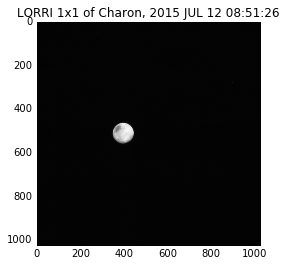

In [76]:
im = hdulist['PRIMARY'].data # Read the data into an array.
plt.imshow(im)               # Show the image to the screen
plt.set_cmap('Greys_r')      # Set the colormap to grey-scale

# Make a plot with a title, converting the ET into a human-readable UTC time

plt.title("{}, {}".format(sapdesc, cspice.et2utc(et, 'C', 0)))
plt.show()

Zoom and crop the image a bit.

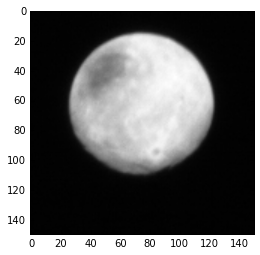

In [47]:
plt.imshow(im[450:600,320:470])  # Show a subset of the image
plt.show()